# CSCI-UA 0480-042 Computer Vision
## Homework 3

Enter your name and NetID below.

#### Name: Kevin Chu
#### NetID: kc4624

The main goals of this assignment include:

1. Giving an introduction to Mask-RCNN
2. Training the predictors for a given dataset
3. Finetuning the entire network for the same dataset

Also accompanying each part, there are a few questions (**12 questions in total**) -- 11 mandatory + 1 extra credit. The first 11 questions are worth 100 points and the extra credit question is worth 10 points. 

Please give your answers in the space provided. This homework has a mix of conceptual and coding questions. You can quickly navigate to coding questions by searching (Ctrl/Cmd-F) for `TODO:`. 

# 1. Introduction to Mask-RCNN

[Mask-RCNN](https://arxiv.org/pdf/1703.06870.pdf) is a network used for instance segmentation. Instance segmentation can be thought of as a hybrid of semantic segmentation and object detection. In other words, we don't want to just find the bounding boxes for each object in our image, we're also interested in finding the segmentation mask of *each object instance*.

![Instance Segmentation as a Hybrid of Semantic Segmentation and Object Detection](../shared/HW3/img/instance_segmentation.png)

Image Credits: https://towardsdatascience.com/single-stage-instance-segmentation-a-review-1eeb66e0cc49

Mask-RCNN is built on top of Faster-RCNN, which is a network used for object detection. Faster-RCNN has 2 outputs for each candidate object (Region of Interest or RoI) - a class label and a bounding box offset. Mask-RCNN adds a third branch to Faster-RCNN for predicting segmentation masks on each RoI.

We'll first briefly go over Faster-RCNN. Faster-RCNN has 2 stages:

1. **Region Proposal Network (RPN):** Given the image, it proposes candidate object bounding boxes. Previous object detection models such as RCNN and Fast-RCNN handled this separately from the CNN model. Faster-RCNN takes a different approach -- it integrates these two components into the same network to achieve speedup.
2. **Fast-RCNN:** This stages takes each candidate RoI and extracts features from the image feature vector using RoIPool. Using these RoI features, it performs classification and bounding box regression.

![Mask-RCNN framework for instance segmentation](../shared/HW3/img/mask_rcnn_architecture.png)

Mask-RCNN has the same 2-stage procedure, but in the 2nd stage, instead of just predicting the classification label and the bounding box offset, it predicts **in parallel** a binary mask for each RoI. 

Mask-RCNN relies on a pretrained network (called the "backbone" in the paper) to extract features from the image. These features are fed into the Region Proposal Network (RPN) to generate candidate RoIs. For each RoI candidate, a fixed size RoI feature vector is generated using an RoIAlign layer. This RoI feature map is then provided to the classifier, bounding box predictor and the segmentation mask to generate the final output.

## Question 1 [10%]

Training uses a multi-task loss function. What are the three components in this loss function? Is the loss computed per image or per RoI?

#### Answer :
Localization Loss (L_loc): This component measures how accurately the model predicts the bounding box coordinates for each Region of Interest (RoI).

Classification Loss (L_cls): This component measures the accuracy of the class predictions for each RoI. It's essentially a classification loss that evaluates whether the model correctly identifies the object category or class within each RoI.

Mask Prediction Loss (L_mask): This component is specific to instance segmentation tasks (e.g., Mask R-CNN). It measures the accuracy of the pixel-wise mask predictions for each RoI.

In the case of object detection and instance segmentation using models like Faster R-CNN or Mask R-CNN, the loss is computed per RoI.

## Question 2 [5%]
[This blog post](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html) by Lilian Weng gives a nice overview of the object detection (RCNN type) networks. In the blog post, it is mentioned that Mask-RCNN uses RoIAlign instead of RoIPool. Explain briefly in 3-4 lines why this is being done.

#### Answer :
RoIAlign eliminates the harsh quantization by utilizing calculations like x/16x/16 instead of [x/16][x/16], allowing the extracted features to be more accurately aligned with the input pixels. This precision is essential for tasks like pixel-level segmentation, which require a higher degree of alignment than what RoIPool can provide

## Question 3 [5%]
What are the different backbones explored in the Mask-RCNN paper? They are denoted in the paper using network-depth-features nomenclature. What is the advantage of using a ResNet-FPN backbone over a ResNet-C4 backbone for feature extraction?

#### Answer :
In the Mask R-CNN paper, the backbones explored include ResNet and ResNeXt networks with depths of either 50 or 101 layers. The backbones are denoted using the nomenclature network-depth-features. For instance, the original implementation of Faster R-CNN with ResNets extracted features from the final convolutional layer of the 4th stage, referred to as C4. Thus, a ResNet-50 backbone in this configuration is denoted as ResNet-50-C4.

The paper also explores the use of a Feature Pyramid Network (FPN) as a more effective backbone. FPN is a top-down architecture with lateral connections, building an in-network feature pyramid from a single-scale input. Using a ResNet-FPN backbone for feature extraction with Mask R-CNN is reported to offer excellent gains in both accuracy and speed.

Generally, FPN architectures are known to improve performance in object detection tasks by efficiently using multi-scale feature maps, which is likely a key factor in their advantages over C4 backbones.

# 2. Training the Predictors for a New Dataset

In this section, we'll start with a pretrained Mask-RCNN model that uses Resnet-50-FPN as the backbone. This model was trained on MS-COCO dataset which is widely used for multiple vision tasks such as object detection, instance segmentation, etc.

MS-COCO has 91 classes (90 for objects + 1 for background). Some sample objects in the dataset include `person`, `car`, `bicycle`, `knife`, `train`, etc. 

Along with this homework file, we have also provided another sample dataset (we'll refer to it as the [Nature dataset](https://towardsdatascience.com/custom-instance-segmentation-training-with-7-lines-of-code-ff340851e99b)). It isn't a standard dataset, but it's small enough (600 train + 200 test images) and allows us to easily demo finetuning a pretrained Mask-RCNN model. This dataset contains only 2 classes - `squirrel` and `butterfly`. 

Our goal in part2 and part3 of this assignment is to take the pretrained Mask-RCNN model and finetune/train it for this dataset. However, here in part2, instead of finetuning the entire network, we'll train only the final layers.

In Homework 2, we've shown how one could feed data into the network using `Dataset`s and `DataLoader`s. We'll use the same strategy here for finetuning the model.

We've based this homework on this [PyTorch tutorial on Object Detection Finetuning](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

## Question 4 [25%]

Complete the TODO section in below cell. Specifically:

1. Read image height, width and polygon shapes data from the JSON file.
2. Generate 2D masks from the polygon points. You can follow this idea: https://stackoverflow.com/a/3732128
3. Generate the bounding boxes from the mask data. Assume that the bounding box is a rectangle with the smallest area enclosing the mask.

You may find this json schema useful:
```
{
   "shapes": [ # list of object instances; masks are represented as polygons
       ## data for instance1 
       {
           "label": "" # label for instance1
           "points": [] # 2d list of polygon points [(x1, y1), (x2, y2), ..]
       },
       ## data for instance2
       {
           "label": []
           "points": []
       },
       
       ..
       ..
   ],
   "imagePath": ""
   "imageData" : ""
   "imageHeight": <integer>
   "imageWidth": <integer>
}
```

In [1]:
# Alternatively, you could also uncomment the line below to see a sample json file
#!cat '../shared/data/HW3/nature/train/s (3).json'

In [2]:
import numpy as np
import torch
import torchvision

import json # for reading from json file
import glob # for listing files inside a folder
from PIL import Image, ImageDraw # for reading images and drawing masks on them.


# Create a custom dataset class for Nature
# dataset subclassing PyTorch's Dataset class
class NatureDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.transforms = transforms
            
        # Load all image files, sorting them to
        # ensure that they are aligned with json files
        imgs = glob.glob(root + '/*.jpg')
        imgs += glob.glob(root + '/*.png') # some images are in png format
        self.imgs = sorted(imgs)
        
        # Mask data is stored in a json file
        masks = glob.glob(root + '/*.json')
        self.masks = sorted(masks)

        # Each image can have multiple object instances, and each
        # instance is associated with either of these 2 labels.

        # Need to convert str-labels to ids. So we'll use 
        # this label-to-index mapping.
        # Note: we can't start from 0 because 0 is restricted
        # to the "background" class
        self.label_to_id = {'squirrel': 1, 'butterfly': 2}

        # Check if any files were found
        if len(self.imgs) == 0 or len(self.masks) == 0:
            raise RuntimeError("No images or JSON files found in the provided directory.")
            
    def __getitem__(self, idx):
        # Have already aligned images and JSON files; can now
        # simply use the index to access both images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        
        # Read image using PIL.Image and convert it to an RGB image
        img = Image.open(img_path).convert("RGB")
        
        # TODO: Read image height, width and mask data from
        # the JSON file
        with open(mask_path, 'r') as fp:
            # TODO: Using json library read the dictionary
            # from the fp
            json_dict = json.load(fp)
            
            # TODO:
            height = json_dict['imageHeight']
            
            # TODO:
            width = json_dict['imageWidth']
            
            # TODO:
            poly_shapes_data = []
            for shape in json_dict['shapes']:
                poly_shapes_data.append({'label':shape['label'], 'points':shape['points']})
        
        # TODO: Each image can have multiple mask instances.
        # Using the polygon points, generate the 2d-mask
        # using PIL's ImageDraw.polygon
        masks = []
        labels = []
        for shape_data in poly_shapes_data:
            polygon_points = [tuple(point) for point in shape_data['points']]
            
            # TODO: Using Image.new() create an image of size (width, height)
            # and fill it with 0s.
            mask_img = Image.new('L', (width, height), 0)
            
            # TODO: Draw the mask on the base image we just created
            ImageDraw.Draw(mask_img).polygon(polygon_points, outline=1, fill=1)

            mask = np.array(mask_img)
            masks.append(mask)

            label = shape_data['label']
            labels.append(label)
        
        # Each mask instance also has an associated label which is str-type
        # Convert the str into an int using the mapping we created in __init__
        labels = [self.label_to_id[label] for label in labels]
        
        # TODO: Generate the bounding boxes for each instance
        # from the 2d masks
        num_objs = len(masks)
        boxes = []
        for i in range(num_objs):
            # TODO: Use np.where() to find where mask[i] == True.
            # pos will be a 2d-list of indices
            pos = np.where(masks[i])
            
            # In pos, find the min x- and y- indices;
            # max x- and y- indices. This will give us our box bounds.
            
            # TODO:
            xmin = np.min(pos[1])
            
            # TODO:
            xmax = np.max(pos[1])
            
            # TODO:
            ymin = np.min(pos[0])
            
            # TODO:
            ymax = np.max(pos[0])
            
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # Apply transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    
    def __len__(self):
        return len(self.imgs)

Having implemented our `NatureDataset` class, let's create the `Dataset` and the `DataLoader` objects. Note that we're not using `torchvision.transforms`, instead we're using transforms provided in a separate script in this directory called `transforms.py`.

In [3]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = NatureDataset('../shared/data/HW3/nature/train', get_transform(train=True))
dataset_test = NatureDataset('../shared/data/HW3/nature/test', get_transform(train=False))

import utils

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)

Now let's visualize one image from our dataset.

/tmp/ipykernel_58/1472686422.py:120: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


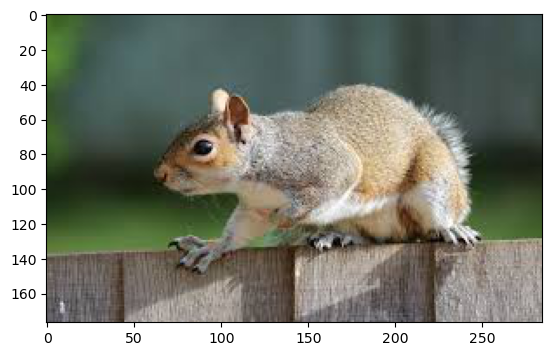

In [4]:
import matplotlib.pyplot as plt

img, targets = dataset[506]

# np.transpose docs: https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
# img is a PyTorch tensor, can convert it to a NumPy tensor by calling .numpy() on it.
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));

And here's the corresponding mask.

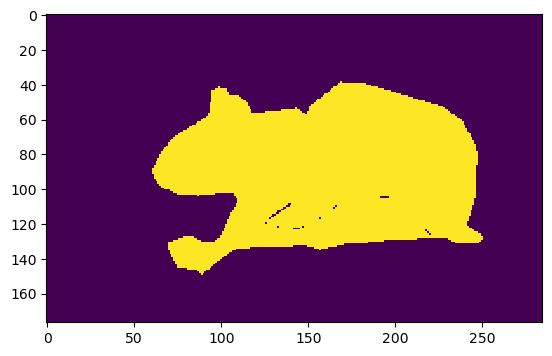

In [5]:
plt.imshow(targets['masks'].numpy().squeeze(), interpolation='none')

We'll be training the final layers of the pretrained Mask-RCNN model (with Resnet-50-FPN backbone) available in the `torchvision` package. So let's download the model:

In [6]:
model_p2 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

/opt/conda/envs/csciua-0480042-fall/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/csciua-0480042-fall/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Question 5 [5%]

Recall what we said earlier: For training for the new dataset, we need to modify its box predictor (FastRCNNPredictor) and its mask predictor (MaskRCNNPredictor) to match with the new dataset. Complete the code cell below.

You may find these docs for `FastRCNNPredictor` and `MaskRCNNPredictor` useful:

![FastRCNNPredictor Docs](../shared/HW3/img/FastRCNNPredictor_docs.png)
![MaskRCNNPredictor Docs](../shared/HW3/img/MaskRCNNPredictor_docs.png)

In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Our new dataset has 3 classes: butterfly, squirrel and background
num_classes = 3

# Get number of input features for the classifier
in_features = model_p2.roi_heads.box_predictor.cls_score.in_features

# TODO: replace the pre-trained head with a new one
model_p2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Get number of input features for the mask predictor
in_features_mask = model_p2.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# TODO: replace the mask predictor with a new one
model_p2.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

Training these layers can take several minutes on a CPU, so we've provided GPUs to make this faster. It should take ~5 mins to run the training in Q7. But before that, we want to ensure that PyTorch is able to access the GPU by printing the device PyTorch is currently (prints `cuda` if it's using a GPU, otherwise it prints `cpu`). 

Now we want to freeze all the layers below these predictors. We can do this by setting the `.requires_grad` attribute of the parameters we want to freeze to `False`. Read more about `requires_grad` from [this PyTorch page on Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html#excluding-subgraphs-from-backward).

In order to do the computation on a GPU, we have to move the model from main memory to GPU memory. This can be done by simply calling `.to(device)` on the model. See [the docs](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) for more information.

### Note : Make sure the below prints `Using : cuda` before proceeding further. If it doesn't print cuda , make sure you are in the GPU profile of the server. To start the server in GPU profile, shutdown the current server and restart the server by selecting the GPU option. 

In [8]:
import itertools

# Freeze model and move it to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using : ", device)

for param in model_p2.parameters():
    param.requires_grad = False

pred_params = itertools.chain(
    model_p2.roi_heads.mask_predictor.parameters(),
    model_p2.roi_heads.box_predictor.parameters()
)

for param in pred_params:
    param.requires_grad = True

model_p2 = model_p2.to(device)

Using :  cuda


We were able to verify that PyTorch is able to access a GPU. Now let's see the layers inside the `model_p2.roi_heads` to understand what we have modified here (we just modified `box_predictor` and `mask_predictor`). You could also verify the output below from figure 4 in the Mask-RCNN paper. You'll notice that it's the exact same network on the right part of that figure.

We can use below command to check what are the GPU devices that are available to us and their current memory usage. Having a GPU in the list doesn't mean we can simply use it for training. We need to have proper CUDA drivers and compatible versions of pytorch/torchvision libraries. We have made sure that the versions are compatible and one is able to use GPU without and additional changes. 

In [9]:
!nvidia-smi

Wed Nov 22 15:17:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |    822MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
model_p2.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=3, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (mask_head): MaskRCNNHeads(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

## Question 6 [10%]
We just printed the head architecture. From the above output, list all the layers we're training along their names. 

For example, if we're training mask_fcn1 of mask_head you'll specify:

`mask_head.mask_fcn1`: 2d-Conv layer with 256 input channels, 256 output channels and kernel size = (2, 2).

Note: We're **only** asking for layers with trainable parameters.

#### Answer :
Box Head Layers:
     box_head.fc6: Linear layer with 12544 input features and 1024 output features.
     box_head.fc7: Linear layer with 1024 input features and 1024 output features.

Box Predictor Layers:
    box_predictor.cls_score: Linear layer with 1024 input features and 3 output features (for class scores).
    box_predictor.bbox_pred: Linear layer with 1024 input features and 12 output features (for bounding box regression).

Mask Head Layers (MaskRCNNHeads):
Each of the Conv2dNormActivation layers (four in total) in mask_head:
    mask_head.0.0: Conv2d layer with 256 input channels, 256 output channels, and a kernel size of (3, 3).
    mask_head.1.0: Conv2d layer with 256 input channels, 256 output channels, and a kernel size of (3, 3).
    mask_head.2.0: Conv2d layer with 256 input channels, 256 output channels, and a kernel size of (3, 3).
    mask_head.3.0: Conv2d layer with 256 input channels, 256 output channels, and a kernel size of (3, 3).

Mask Predictor Layers:
        mask_predictor.conv5_mask: ConvTranspose2d layer with 256 input channels, 256 output channels, and a kernel size of (2, 2).
        mask_predictor.mask_fcn_logits: Conv2d layer with 256 input channels, 3 output channels (for mask predictions), and a kernel size of (1, 1).

Both the dataloaders and model have been prepared for training. All that remains is to set an optimizer and a learning rate scheduler. When we create an optimizer, we have to provide it the list of trainable parameters.

In [11]:
# Declare optimizer and lr
params = [p for p in model_p2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

## Question 7 [10%]

How many trainable parameters are we passing to the optimizer?

Here's an example to calculate # of trainable parameters in a fully connected layer with:
1. an additive bias
2. in_channels = 1024
3. out_channels = 10

The number of trainable parameters here will be 1024\*10 + 10 = 10250.

#### Answer :
16,534,546

Box Head Layers:

box_head.fc6: Linear layer with 12544 input features and 1024 output features.
Parameters: 12544×1024+102412544×1024+1024 (weights + bias)

box_head.fc7: Linear layer with 1024 input features and 1024 output features.
Parameters: 1024×1024+10241024×1024+1024 (weights + bias)

Box Predictor Layers:

box_predictor.cls_score: Linear layer with 1024 input features and 3 output features.

Parameters: 1024×3+31024×3+3 (weights + bias)

box_predictor.bbox_pred: Linear layer with 1024 input features and 12 output features.

Parameters: 1024×12+121024×12+12 (weights + bias)

Mask Head Layers:
Each Conv2dNormActivation layer (4 in total) in mask_head has 256 input channels, 256 output channels, and a 3x3 kernel size.

Parameters per layer: 256×256×3×3+256256×256×3×3+256 (weights + bias)
Total for all layers: 256×256×3×3+256256×256×3×3+256 ×4×4

Mask Predictor Layers:
mask_predictor.conv5_mask: ConvTranspose2d layer with 256 input channels, 256 output channels, and a 2x2 kernel size.

Parameters: 256×256×2×2+256256×256×2×2+256 (weights + bias)

mask_predictor.mask_fcn_logits: Conv2d layer with 256 input channels, 3 output channels, and a 1x1 kernel size.

Parameters: 256×3+3256×3+3 (weights + bias)

Box Head Layers: 12544×1024+1024+1024×1024+102412544×1024+1024+1024×1024+1024

Box Predictor Layers: 
1024×3+3+1024×12+121024×3+3+1024×12+12

Mask Head Layers: 
(256×256×3×3+256)×4(256×256×3×3+256)×4

Mask Predictor Layers: 
256×256×2×2+256+256×3+3256×256×2×2+256+256×3+3

Now we can finally start the training process.

In [12]:
num_epochs = 3

from engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
    print("Epoch", epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_p2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_p2, data_loader_test, device=device)

Epoch 0


/opt/conda/envs/csciua-0480042-fall/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: [0]  [  0/300]  eta: 0:20:06  lr: 0.000022  loss: 5.6961 (5.6961)  loss_classifier: 1.2667 (1.2667)  loss_box_reg: 0.1699 (0.1699)  loss_mask: 4.2501 (4.2501)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 4.0202  data: 0.0319  max mem: 861
Epoch: [0]  [ 10/300]  eta: 0:02:55  lr: 0.000189  loss: 4.0994 (4.1485)  loss_classifier: 1.1870 (1.0890)  loss_box_reg: 0.1494 (0.1437)  loss_mask: 2.7558 (2.8928)  loss_objectness: 0.0042 (0.0051)  loss_rpn_box_reg: 0.0113 (0.0180)  time: 0.6047  data: 0.0267  max mem: 1043
Epoch: [0]  [ 20/300]  eta: 0:02:03  lr: 0.000356  loss: 2.7392 (3.0010)  loss_classifier: 0.5954 (0.7193)  loss_box_reg: 0.1481 (0.1438)  loss_mask: 1.6618 (2.1120)  loss_objectness: 0.0053 (0.0063)  loss_rpn_box_reg: 0.0113 (0.0195)  time: 0.2611  data: 0.0253  max mem: 1172
Epoch: [0]  [ 30/300]  eta: 0:01:43  lr: 0.000523  loss: 1.1208 (2.3208)  loss_classifier: 0.1756 (0.5374)  loss_box_reg: 0.1410 (0.1472)  loss_mask: 0.7196 (1.6151)  

Epoch: [0]  [299/300]  eta: 0:00:00  lr: 0.005000  loss: 0.4192 (0.8032)  loss_classifier: 0.0329 (0.1189)  loss_box_reg: 0.0656 (0.1145)  loss_mask: 0.2945 (0.5509)  loss_objectness: 0.0018 (0.0054)  loss_rpn_box_reg: 0.0070 (0.0135)  time: 0.2723  data: 0.0243  max mem: 1610
Epoch: [0] Total time: 0:01:25 (0.2859 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:00:38  model_time: 0.1758 (0.1758)  evaluator_time: 0.0070 (0.0070)  time: 0.1931  data: 0.0099  max mem: 1610
Test:  [100/200]  eta: 0:00:13  model_time: 0.1252 (0.1223)  evaluator_time: 0.0051 (0.0047)  time: 0.1413  data: 0.0102  max mem: 1610
Test:  [199/200]  eta: 0:00:00  model_time: 0.1254 (0.1228)  evaluator_time: 0.0044 (0.0045)  time: 0.1414  data: 0.0132  max mem: 1610
Test: Total time: 0:00:27 (0.1385 s / it)
Averaged stats: model_time: 0.1254 (0.1228)  evaluator_time: 0.0044 (0.0045)
Accumulating evaluation results...
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: b

Epoch: [1]  [190/300]  eta: 0:00:31  lr: 0.005000  loss: 0.4555 (0.4850)  loss_classifier: 0.0364 (0.0454)  loss_box_reg: 0.0735 (0.0759)  loss_mask: 0.3025 (0.3438)  loss_objectness: 0.0037 (0.0062)  loss_rpn_box_reg: 0.0095 (0.0138)  time: 0.2846  data: 0.0224  max mem: 1610
Epoch: [1]  [200/300]  eta: 0:00:28  lr: 0.005000  loss: 0.5170 (0.4883)  loss_classifier: 0.0363 (0.0456)  loss_box_reg: 0.0770 (0.0767)  loss_mask: 0.4030 (0.3460)  loss_objectness: 0.0042 (0.0063)  loss_rpn_box_reg: 0.0095 (0.0137)  time: 0.2863  data: 0.0244  max mem: 1610
Epoch: [1]  [210/300]  eta: 0:00:25  lr: 0.005000  loss: 0.3776 (0.4840)  loss_classifier: 0.0335 (0.0457)  loss_box_reg: 0.0619 (0.0770)  loss_mask: 0.2374 (0.3412)  loss_objectness: 0.0033 (0.0062)  loss_rpn_box_reg: 0.0083 (0.0139)  time: 0.2825  data: 0.0239  max mem: 1610
Epoch: [1]  [220/300]  eta: 0:00:22  lr: 0.005000  loss: 0.3584 (0.4808)  loss_classifier: 0.0363 (0.0455)  loss_box_reg: 0.0619 (0.0768)  loss_mask: 0.2206 (0.3386) 

Epoch: [2]  [ 80/300]  eta: 0:01:04  lr: 0.005000  loss: 0.3182 (0.4307)  loss_classifier: 0.0308 (0.0407)  loss_box_reg: 0.0596 (0.0701)  loss_mask: 0.2065 (0.3002)  loss_objectness: 0.0037 (0.0061)  loss_rpn_box_reg: 0.0064 (0.0137)  time: 0.2947  data: 0.0204  max mem: 1611
Epoch: [2]  [ 90/300]  eta: 0:01:00  lr: 0.005000  loss: 0.3731 (0.4357)  loss_classifier: 0.0308 (0.0412)  loss_box_reg: 0.0596 (0.0709)  loss_mask: 0.2497 (0.3045)  loss_objectness: 0.0052 (0.0062)  loss_rpn_box_reg: 0.0067 (0.0129)  time: 0.2831  data: 0.0211  max mem: 1611
Epoch: [2]  [100/300]  eta: 0:00:57  lr: 0.005000  loss: 0.4087 (0.4478)  loss_classifier: 0.0380 (0.0413)  loss_box_reg: 0.0653 (0.0716)  loss_mask: 0.3017 (0.3162)  loss_objectness: 0.0036 (0.0059)  loss_rpn_box_reg: 0.0065 (0.0127)  time: 0.2658  data: 0.0213  max mem: 1611
Epoch: [2]  [110/300]  eta: 0:00:54  lr: 0.005000  loss: 0.3854 (0.4415)  loss_classifier: 0.0315 (0.0409)  loss_box_reg: 0.0508 (0.0706)  loss_mask: 0.2620 (0.3108) 

In order to analyze the output, you'll need to know what an IoU score is. You can read this blog: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

## Question 8 [10%]

In an image (grey box) of size 12x16, there is an object whose ground truth mask is the box with the dashed edge (green color) and the model's predicted mask is the box with the dash-dotted edge (red color). Calculate the IoU score for this prediction.

![Image](../shared/HW3/img/plot.png)

#### Answer :
IoU = Area of overlap / Area of Union

Area of Overlap = (10-5) * (14-10) = 20

Area of Union = (11 - 4) * (14-9) + (10 - 5) * (15-14) = 40

IoU = 20/40 = 0.5

Let's see the model's prediction for a sample from the test set.

In [13]:
img, target = dataset_test[1]

# put the model in evaluation mode
model_p2.eval()

with torch.no_grad():
    prediction = model_p2([img.to(device)])

Here's the sample image.

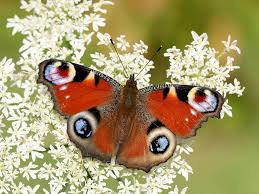

In [14]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And here's the mask generated by the finetuned model.

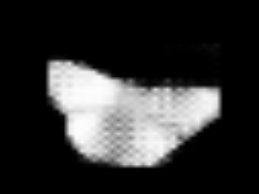

In [15]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

# 3. Finetuning the Entire Network

Let's see what happens when we fine-tune the entire network. That is, instead of just learning the weights in the final layers, we'll let the weights of the entire network change during the training process.

In [16]:
model_p3 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

## Question 9 [5%]

Just like in question 5, we're interested in fine-tuning the pretrained model for our new dataset, so we will again need to modify its box predictor (FastRCNNPredictor) and its mask predictor (MaskRCNNPredictor) to match with our new dataset. Complete the code cell below. Hint: This is exactly the same as question 5.

In [17]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Our new dataset has 3 classes: butterfly, squirrel and background
num_classes = 3

# Get number of input features for the classifier
in_features = model_p3.roi_heads.box_predictor.cls_score.in_features

# TODO: replace the pre-trained head with a new one
model_p3.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Get number of input features for the mask predictor
in_features_mask = model_p3.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# TODO: replace the mask predictor with a new one
model_p3.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

Again, let's ensure that we're using the GPU by printing the device info. This finetuning process takes even longer because we have more trainable parameters, hence there will be more computations.

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using : ", device)

model_p3 = model_p3.to(device)

Using :  cuda


We'll use the same optimizer and learning rate scheduler as before.

In [19]:
params = [p for p in model_p3.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

Let's start the finetuning process.

In [20]:
num_epochs = 3

from engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
    print("Epoch", epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_p3, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_p3, data_loader_test, device=device)

Epoch 0
Epoch: [0]  [  0/300]  eta: 0:03:17  lr: 0.000022  loss: 5.8146 (5.8146)  loss_classifier: 1.7740 (1.7740)  loss_box_reg: 0.1845 (0.1845)  loss_mask: 3.8510 (3.8510)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.6579  data: 0.0221  max mem: 2767
Epoch: [0]  [ 10/300]  eta: 0:03:06  lr: 0.000189  loss: 3.9518 (4.3597)  loss_classifier: 1.4907 (1.4081)  loss_box_reg: 0.1300 (0.1304)  loss_mask: 2.3368 (2.7941)  loss_objectness: 0.0048 (0.0086)  loss_rpn_box_reg: 0.0134 (0.0186)  time: 0.6443  data: 0.0220  max mem: 4135
Epoch: [0]  [ 20/300]  eta: 0:02:52  lr: 0.000356  loss: 1.8819 (2.8972)  loss_classifier: 0.5909 (0.8655)  loss_box_reg: 0.1120 (0.1169)  loss_mask: 1.1474 (1.8691)  loss_objectness: 0.0169 (0.0264)  loss_rpn_box_reg: 0.0143 (0.0193)  time: 0.6140  data: 0.0219  max mem: 4135
Epoch: [0]  [ 30/300]  eta: 0:02:44  lr: 0.000523  loss: 1.0688 (2.2729)  loss_classifier: 0.1377 (0.6232)  loss_box_reg: 0.1002 (0.1131)  loss_mask: 0.7222 (

Epoch: [0]  [299/300]  eta: 0:00:00  lr: 0.005000  loss: 0.4886 (0.7526)  loss_classifier: 0.0531 (0.1304)  loss_box_reg: 0.0767 (0.1175)  loss_mask: 0.3275 (0.4767)  loss_objectness: 0.0111 (0.0124)  loss_rpn_box_reg: 0.0084 (0.0155)  time: 0.6205  data: 0.0226  max mem: 4139
Epoch: [0] Total time: 0:03:05 (0.6190 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:00:39  model_time: 0.1817 (0.1817)  evaluator_time: 0.0066 (0.0066)  time: 0.1984  data: 0.0097  max mem: 4139
Test:  [100/200]  eta: 0:00:14  model_time: 0.1338 (0.1289)  evaluator_time: 0.0074 (0.0069)  time: 0.1498  data: 0.0101  max mem: 4139
Test:  [199/200]  eta: 0:00:00  model_time: 0.1352 (0.1304)  evaluator_time: 0.0072 (0.0069)  time: 0.1498  data: 0.0115  max mem: 4139
Test: Total time: 0:00:29 (0.1483 s / it)
Averaged stats: model_time: 0.1352 (0.1304)  evaluator_time: 0.0072 (0.0069)
Accumulating evaluation results...
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: b

Epoch: [1]  [190/300]  eta: 0:01:07  lr: 0.005000  loss: 0.2908 (0.4335)  loss_classifier: 0.0414 (0.0530)  loss_box_reg: 0.0658 (0.0795)  loss_mask: 0.1471 (0.2806)  loss_objectness: 0.0041 (0.0072)  loss_rpn_box_reg: 0.0062 (0.0132)  time: 0.5999  data: 0.0211  max mem: 4505
Epoch: [1]  [200/300]  eta: 0:01:01  lr: 0.005000  loss: 0.3182 (0.4422)  loss_classifier: 0.0392 (0.0540)  loss_box_reg: 0.0614 (0.0797)  loss_mask: 0.2028 (0.2881)  loss_objectness: 0.0050 (0.0072)  loss_rpn_box_reg: 0.0072 (0.0132)  time: 0.6167  data: 0.0214  max mem: 4505
Epoch: [1]  [210/300]  eta: 0:00:55  lr: 0.005000  loss: 0.4119 (0.4408)  loss_classifier: 0.0425 (0.0535)  loss_box_reg: 0.0616 (0.0793)  loss_mask: 0.2802 (0.2876)  loss_objectness: 0.0063 (0.0071)  loss_rpn_box_reg: 0.0082 (0.0133)  time: 0.6567  data: 0.0234  max mem: 4505
Epoch: [1]  [220/300]  eta: 0:00:49  lr: 0.005000  loss: 0.3547 (0.4359)  loss_classifier: 0.0387 (0.0530)  loss_box_reg: 0.0666 (0.0796)  loss_mask: 0.1791 (0.2833) 

Epoch: [2]  [ 80/300]  eta: 0:02:16  lr: 0.005000  loss: 0.2816 (0.3149)  loss_classifier: 0.0334 (0.0414)  loss_box_reg: 0.0611 (0.0676)  loss_mask: 0.1722 (0.1893)  loss_objectness: 0.0042 (0.0045)  loss_rpn_box_reg: 0.0052 (0.0121)  time: 0.5976  data: 0.0217  max mem: 4505
Epoch: [2]  [ 90/300]  eta: 0:02:10  lr: 0.005000  loss: 0.2398 (0.3096)  loss_classifier: 0.0318 (0.0404)  loss_box_reg: 0.0552 (0.0670)  loss_mask: 0.1267 (0.1853)  loss_objectness: 0.0034 (0.0044)  loss_rpn_box_reg: 0.0062 (0.0125)  time: 0.6119  data: 0.0213  max mem: 4505
Epoch: [2]  [100/300]  eta: 0:02:04  lr: 0.005000  loss: 0.2263 (0.3053)  loss_classifier: 0.0257 (0.0396)  loss_box_reg: 0.0527 (0.0679)  loss_mask: 0.1258 (0.1814)  loss_objectness: 0.0020 (0.0042)  loss_rpn_box_reg: 0.0093 (0.0122)  time: 0.6215  data: 0.0230  max mem: 4505
Epoch: [2]  [110/300]  eta: 0:01:58  lr: 0.005000  loss: 0.2180 (0.3050)  loss_classifier: 0.0257 (0.0389)  loss_box_reg: 0.0504 (0.0676)  loss_mask: 0.1377 (0.1815) 

We'll generate the output for the same image, but this time with the new finetuned model.

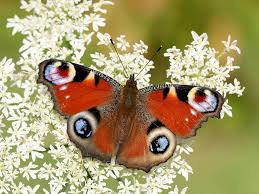

In [21]:
img, target = dataset_test[1]

# put the model in evaluation mode
model_p3.eval()
with torch.no_grad():
    prediction = model_p3([img.to(device)])

Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Here's the predicted image.

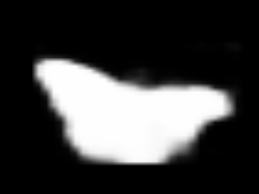

In [22]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

## Question 10 [5%]

Does this model perform better than the trained model after Q7 ? How do you campare these models ? Explain why the model performs better than the other model.

#### Answer :
The new model has led to a reduction in losses across all categories, with a notable improvement in mask prediction.
The evaluation metrics post-training show a considerable improvement, indicating enhanced accuracy and reliability of the model.

It's clear that the new model performed better, as evidenced by the improved performance metrics. This suggests that the model is now better at generalizing and making accurate predictions, particularly in terms of mask prediction.

Before:

Epoch 0: The initial losses are relatively high, with the loss_mask being the highest. This suggests the model initially struggled more with mask prediction.

Epoch 1: There is a noticeable reduction in losses across all categories, indicating that the model is learning and improving its performance.

Epoch 2: Further reduction in losses, showing continued learning and improvement.

Evaluation Metrics (IoU metric: bbox and segm): The Average Precision (AP) and Average Recall (AR) across different IoUs (Intersection over Union) and areas show the model's performance after the initial training phase. The AP and AR values are moderate, indicating a fair performance but with room for improvement.

After:

Epoch 0: The losses start at a lower point compared to the 'before' training scenario. This suggests that the modifications or continued training has had a positive effect.

Epoch 1: There's a further reduction in losses, with loss_mask still being the highest but lower than the initial 'before training' values.

Epoch 2: Continued reduction in losses, with a more noticeable decrease in loss_mask, indicating improved mask prediction capabilities.

Evaluation Metrics (IoU metric: bbox and segm): There is a significant improvement in AP and AR values across different IoUs and areas. The model shows better accuracy and recall, suggesting that the changes made have positively impacted its performance.

## Question 11 [10 %]

Discuss any 4 advantage of using CONV layers over FC/Dense layers?

#### Answer :
Parameter Efficiency: 

CONV layers are significantly more parameter-efficient compared to FC layers. In a CONV layer, weights are shared across the input image through the convolution operation, meaning the same filter (set of weights) is used to scan the entire image. This results in a much smaller number of parameters, which not only reduces the memory usage but also helps to alleviate overfitting.

Spatial Hierarchies of Features: 

Convolutional layers are adept at capturing the spatial hierarchies in images. Lower layers might capture edges or textures, while deeper layers can learn more complex patterns or objects. This is because the convolution operation preserves the spatial relationship between pixels by learning image features using small squares of input data. FC layers, on the other hand, do not leverage spatial hierarchies, as they treat input data as a flat vector.

Translation Invariance: 

Due to the nature of the convolution operation and pooling layers often used with CONV layers, convolutional neural networks (CNNs) are more translation-invariant compared to models with only FC layers. This means that a CNN can recognize an object in an image, no matter where it is located in the picture. FC layers lack this property because each neuron is connected to every input, leading to a strict dependence on the position of features in the input space.

Locality and Receptive Fields: 

CONV layers have local receptive fields, meaning each neuron in a CONV layer is connected to only a small region of the input. This allows the network to capture local features (like edges in an image) before integrating them into more global features in deeper layers. FC layers do not have this property; each neuron in an FC layer is connected to every input feature, which makes them less effective in capturing local patterns within input data.

# 4. Extra Credit Questions

## Question 12 [10 points]

Can fully convolutional networks (FCN) be used for object detection? In Mask-RCNN we have 3 branches — mask, classification, and bounding box regression — out of which the last 2 have fully connected (FC) layers. Can this entire pipeline be replaced by a fully convolutional network? If possible, discuss any 2 networks to support your claim explaining their architecture.

#### Answer :
Fully Convolutional Networks (FCN) can be used for object detection, and there are architectures that have successfully replaced parts of the pipeline traditionally relying on Fully Connected (FC) layers with convolutional layers. This approach offers several benefits, including the ability to handle input images of various sizes and improved efficiency in terms of parameter usage. Here are two notable examples of such architectures:
1. YOLO (You Only Look Once)

    Architecture: YOLO is a groundbreaking object detection system that reframes object detection as a single regression problem, straight from image pixels to bounding box coordinates and class probabilities. It divides the input image into a grid, and each grid cell predicts a certain number of bounding boxes and class probabilities for those boxes. The key aspect here is that YOLO uses convolutional layers not only for feature extraction but also for predicting bounding boxes and class probabilities. This makes it a fully convolutional network.

2. SSD (Single Shot MultiBox Detector)

    Architecture: SSD, like YOLO, is another one-stage detector that uses a fully convolutional network. It discretizes the output space of bounding boxes into a set of default boxes over different aspect ratios and scales per feature map location. During prediction, the network generates scores for the presence of each object category in each default box and adjusts the box to better match the object shape. The network combines predictions from multiple feature maps with different resolutions to naturally handle objects of various sizes.